In [48]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [2]:
# Load the disaster data
disaster_df = pd.read_csv(r'D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\disaster\fema_disaster_with_noaa_monthly_temp_combined.csv')

C:\Users\Alex Hoang\AppData\Local\Temp\ipykernel_37516\4108214428.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  disaster_df = pd.read_csv(r'D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\disaster\fema_disaster_with_noaa_monthly_temp_combined.csv')


In [3]:
# remove the rows with missing values
disaster_df = disaster_df.drop(columns=['Unnamed: 0', 'last_ia_filing_date'])
disaster_df = disaster_df.dropna()


In [4]:
# Count total number of disaster events of each state per year based on the number of time the state appears that year
# Ensure relevant columns are of the correct data type
disaster_df['State'] = disaster_df['State'].astype(str)
disaster_df['year'] = disaster_df['year'].astype(str)

# Group by 'State' and 'year' and count the occurrences
disaster_counts = disaster_df.groupby(['State', 'year']).size().reset_index(name='total_disasters')

# Pivot the DataFrame to get the desired format
pivot_df = disaster_counts.pivot(index='year', columns='State', values='total_disasters').fillna(0).astype(int)


In [45]:
def plot_co2_and_disasters(co2_dir, pivot_df, output_dir, year_range, states=False):
    """
    Plot the total CO2 emissions and disaster events per year.
    
    Parameters:
        co2_dir (str): Directory containing the CO2 emissions data files.
        pivot_df (pd.DataFrame): Pivot table of disaster events data.
        output_dir (str): Directory to save the generated plots.
        range (tuple): Range of years to include in the plot.
        states (bool): If True, plot the data for each state separately.
    
    Returns:
    """
    if states:
        # Load all CO2 emissions CSV files and aggregate the data
        co2_file_paths = glob.glob(os.path.join(co2_dir, '*.csv'))
        co2_df_list = []
        for co2_file in co2_file_paths:
            df = pd.read_csv(co2_file)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df['year'] = df['datetime'].dt.year.astype(int)
            df = df.groupby('year')['sum'].sum().reset_index(name='total_co2_emissions')
            co2_df_list.append(df)
        
        # Concatenate all CO2 dataframes and aggregate by year
        co2_df = pd.concat(co2_df_list)
        co2_df = co2_df.groupby('year')['total_co2_emissions'].sum().reset_index()

        # Ensure the pivot table index is of the correct data type
        pivot_df.index = pivot_df.index.astype(int)

        # Filter the pivot table to include only the years in the specified range
        pivot_df_filtered = pivot_df[(pivot_df.index >= year_range[0]) & (pivot_df.index <= year_range[1])]

        # Aggregate the disaster events data for the entire US
        total_disasters_df = pivot_df_filtered.sum(axis=1).reset_index(name='total_disasters')

        # Merge the CO2 emissions data with the disaster events data
        merged_df = pd.merge(co2_df, total_disasters_df, left_on='year', right_on='year', how='inner')

        # Plot the data
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # Plot CO2 emissions
        ax1.set_xlabel('Year')
        ax1.set_ylabel('CO2 Emissions (tonne CO₂/km²/year)', color='tab:blue')
        ax1.plot(merged_df['year'], merged_df['total_co2_emissions'], label='US CO2', color='tab:blue', linestyle='--', marker='o')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

        # Create a second y-axis to plot disaster events
        ax2 = ax1.twinx()
        ax2.set_ylabel('Total Disasters', color='tab:red')
        ax2.plot(merged_df['year'], merged_df['total_disasters'], label='US Disasters', color='tab:red', marker='o')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Add legends
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

        plt.title(f'Total CO2 Emissions and Disaster Events per Year in the US ({year_range[0]}-{year_range[1]})')
        plt.savefig(os.path.join(output_dir, 'us_co2_disasters.png'))
        plt.close()
    else:
        for co2_file in os.listdir(co2_dir):
            if co2_file.endswith('.csv'):
                # Extract the state name from the CO2 emission file name
                state_name = os.path.basename(co2_file).split('-')[0]
                file_path = os.path.join(co2_dir, co2_file)
                print(file_path)
                # Load the CO2 emissions data
                co2_df = pd.read_csv(file_path)

                # Ensure the 'year' column is of the correct data type
                co2_df['datetime'] = pd.to_datetime(co2_df['datetime'])
                co2_df['year'] = co2_df['datetime'].dt.year.astype(int)

                # Group by 'year' and sum the 'sum' column
                co2_df = co2_df.groupby('year')['sum'].sum().reset_index(name='total_co2_emissions')

                pivot_df.index = pivot_df.index.astype(int)
                # Filter the pivot table to include only the years 2010 to 2021
                pivot_df_filtered = pivot_df[(pivot_df.index >= year_range[0]) & (pivot_df.index <= year_range[1])]

                # Merge the disaster events data with the CO2 emissions data
                merged_df = pd.merge(co2_df, pivot_df_filtered, left_on='year', right_index=True, how='inner')

                # Plot the data
                fig, ax1 = plt.subplots(figsize=(14, 8))

                # Plot CO2 emissions
                ax1.set_xlabel('Year')
                ax1.set_ylabel('CO2 Emissions (tonne CO₂/km²/year)', color='tab:blue')
                ax1.set_xticks(merged_df['year'])
                ax1.plot(merged_df['year'], merged_df['total_co2_emissions'], label=f'{state_name} CO2', color='tab:blue', linestyle='--', marker='o')
                ax1.tick_params(axis='y', labelcolor='tab:blue')
                ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


                # Create a second y-axis to plot disaster events
                ax2 = ax1.twinx()
                ax2.set_ylabel('Total Disasters', color='tab:red')
                if state_name in pivot_df.columns:
                    ax2.plot(merged_df['year'], merged_df[state_name], label=f'{state_name} Disasters', color='tab:red', marker='o')
                ax2.tick_params(axis='y', labelcolor='tab:red')

                # Add legends
                fig.tight_layout()
                fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

                plt.title(f'Total CO2 Emissions and Disaster Events per Year in {state_name} ({year_range[0]}-{year_range[1]})')
                plt.savefig(f'{output_dir}\{state_name}_co2_disasters.png')
                plt.show()

                plt.close()

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Alabama-total-co2.csv


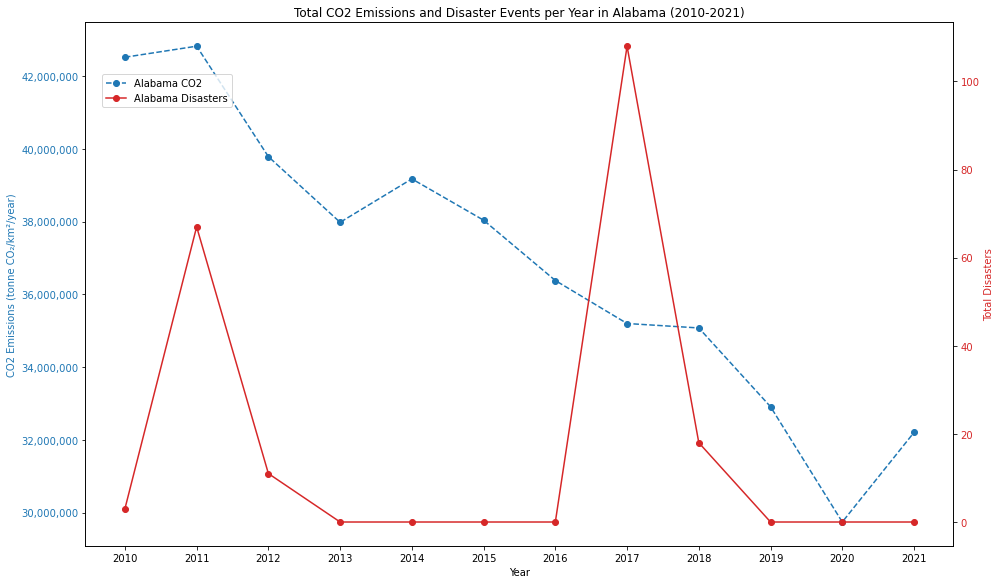

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Arizona-total-co2.csv


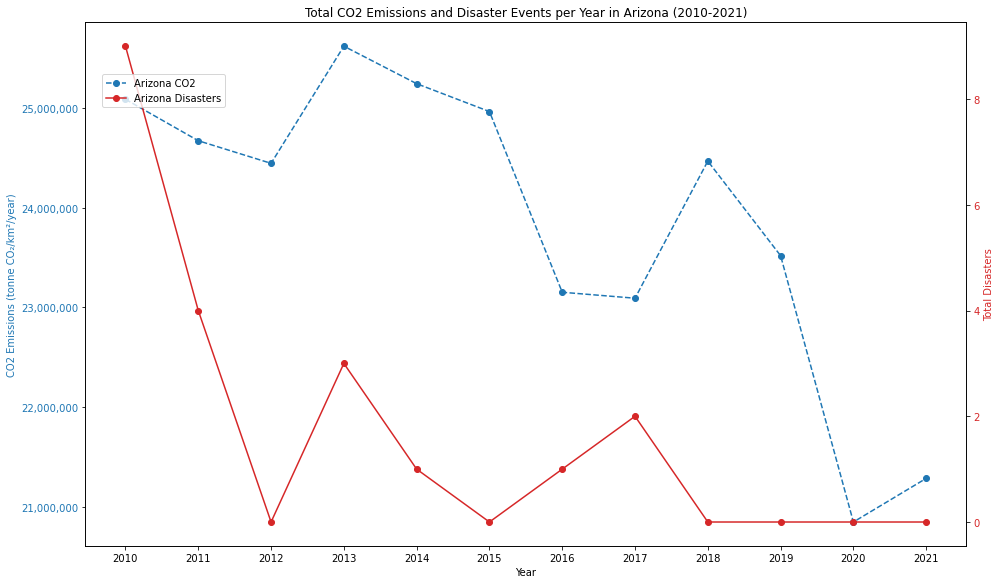

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Arkansas-total-co2.csv


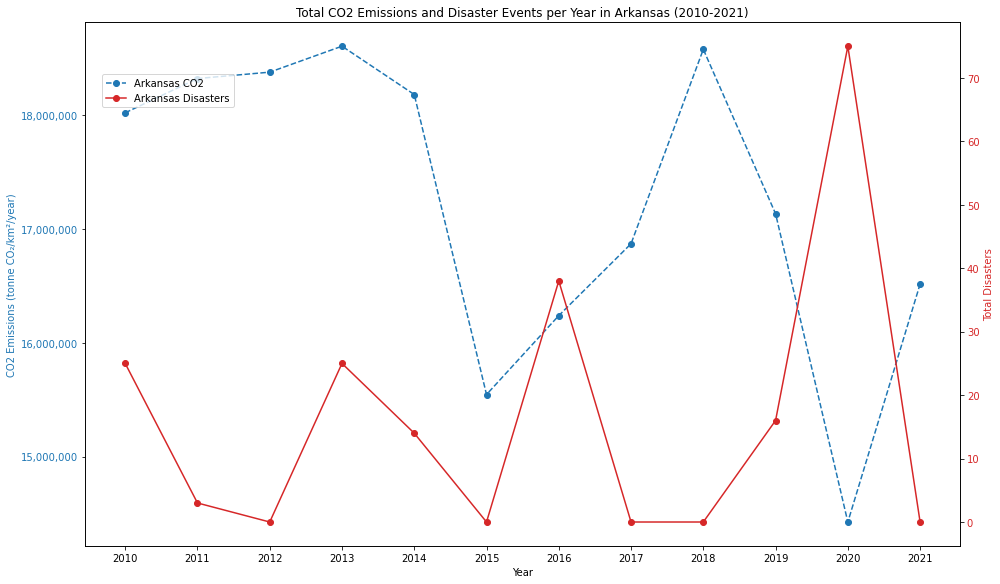

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\California-total-co2.csv


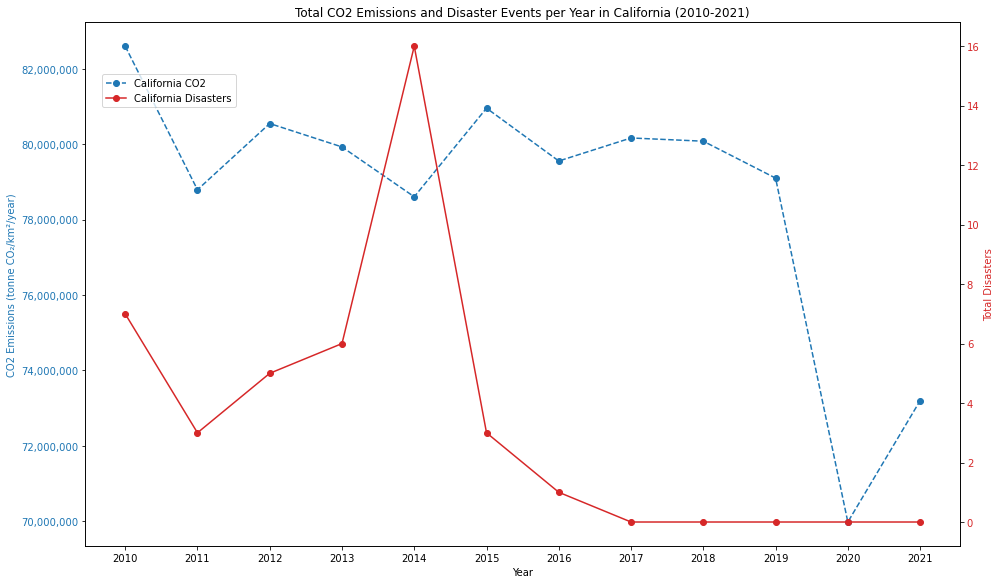

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Colorado-total-co2.csv


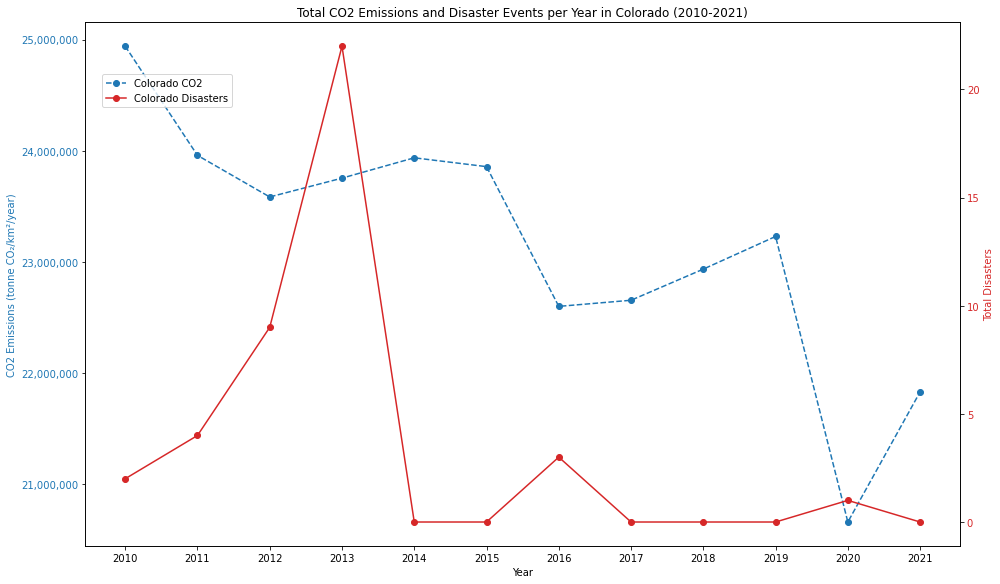

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Connecticut-total-co2.csv


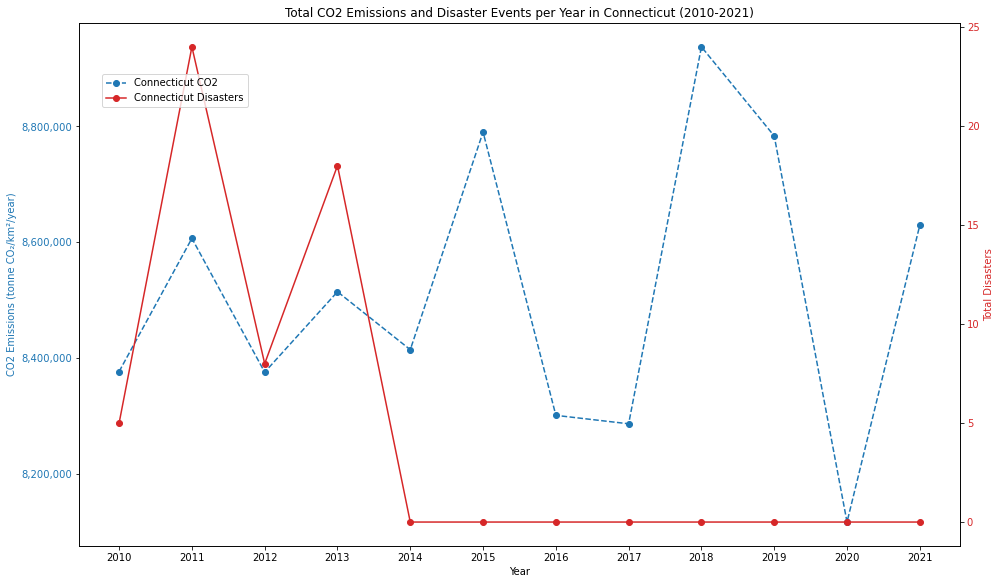

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Delaware-total-co2.csv


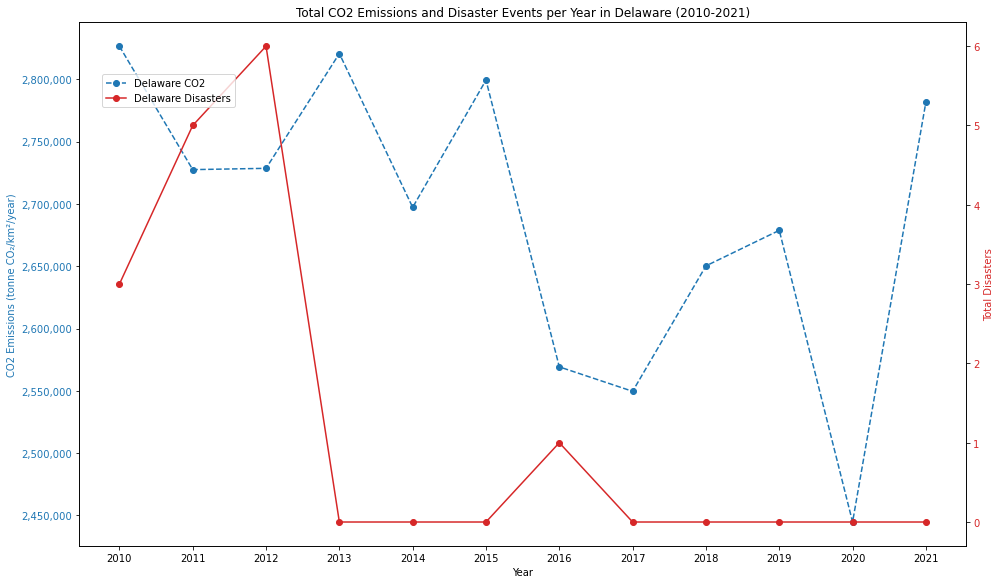

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\District of Columbia-total-co2.csv


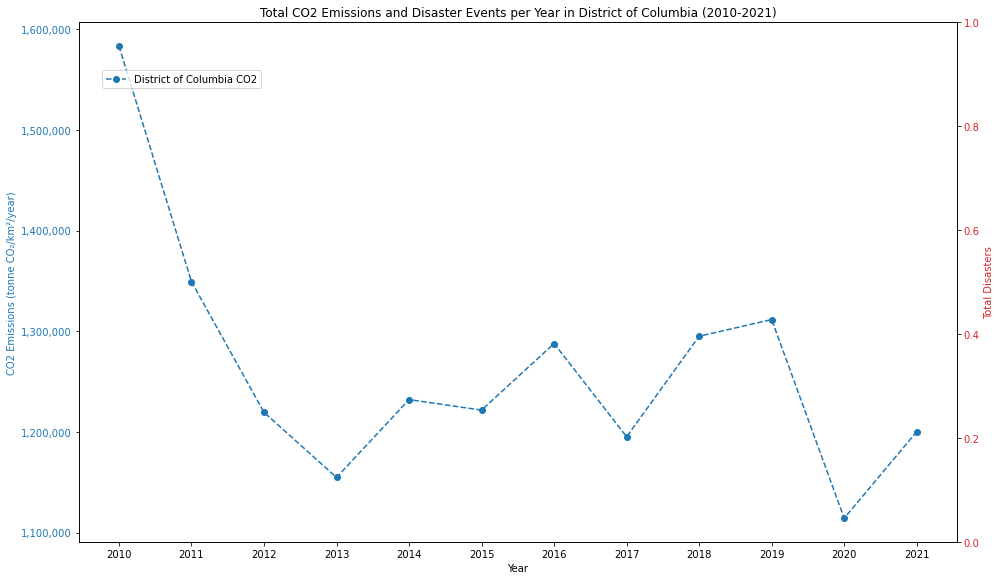

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Florida-total-co2.csv


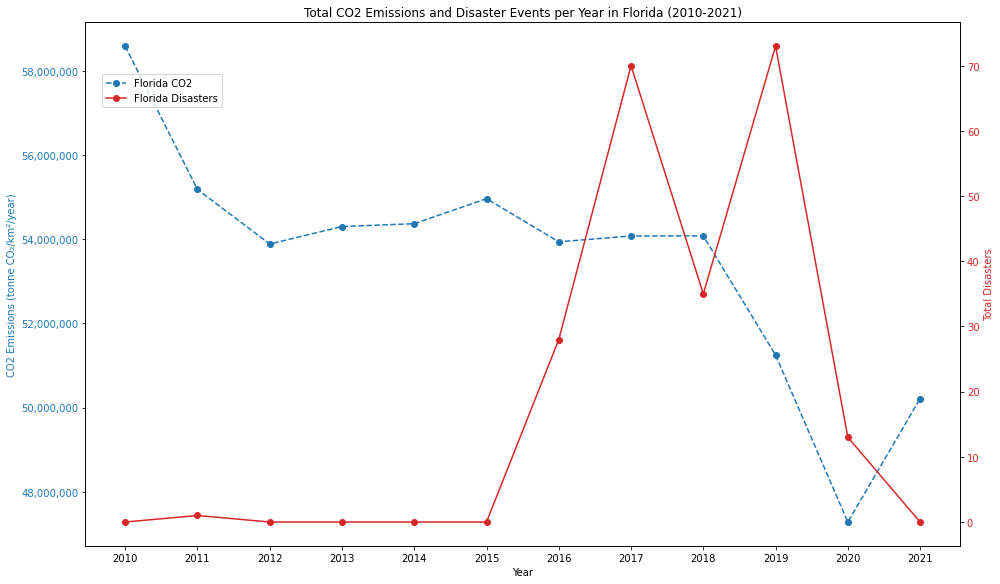

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Georgia-total-co2.csv


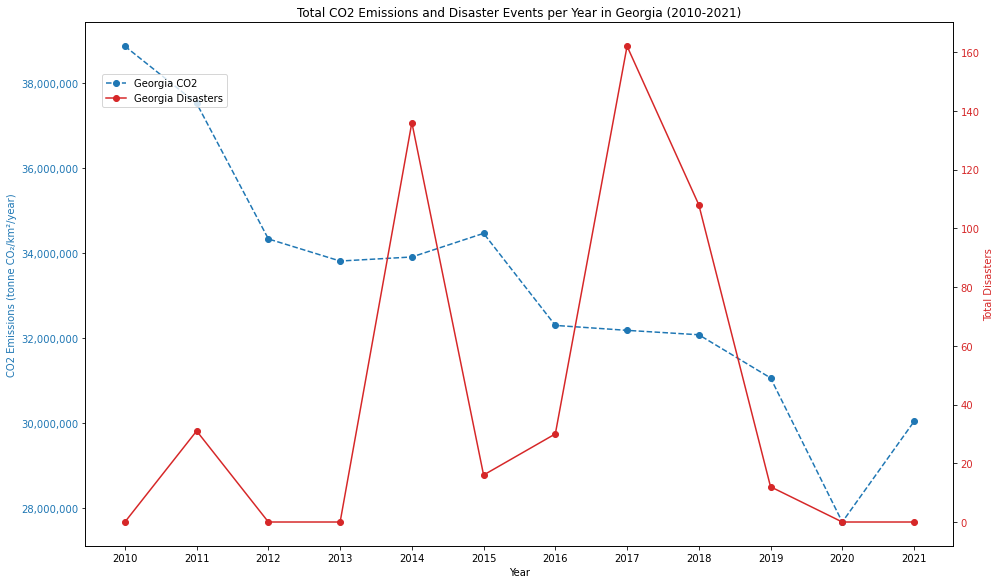

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Idaho-total-co2.csv


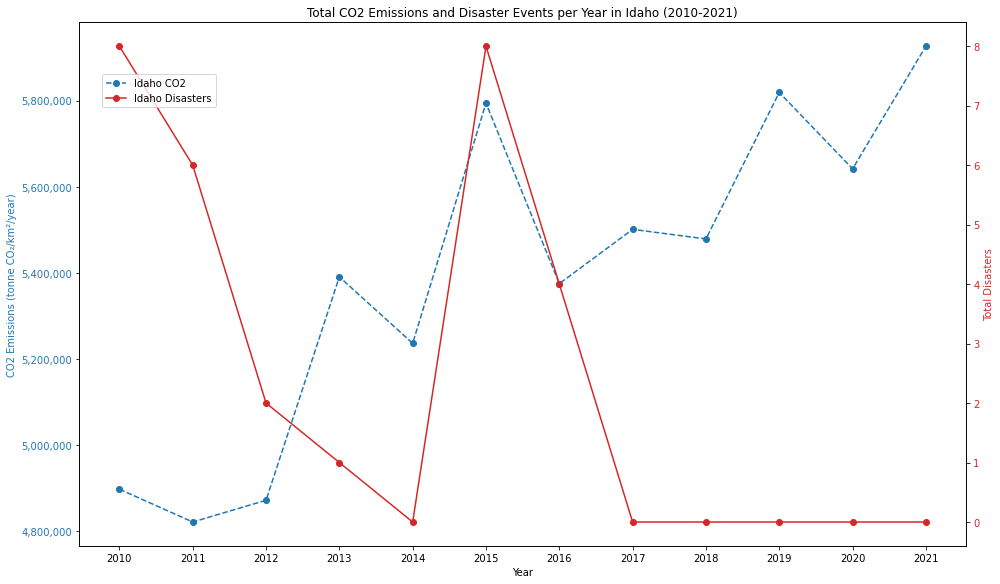

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Illinois-total-co2.csv


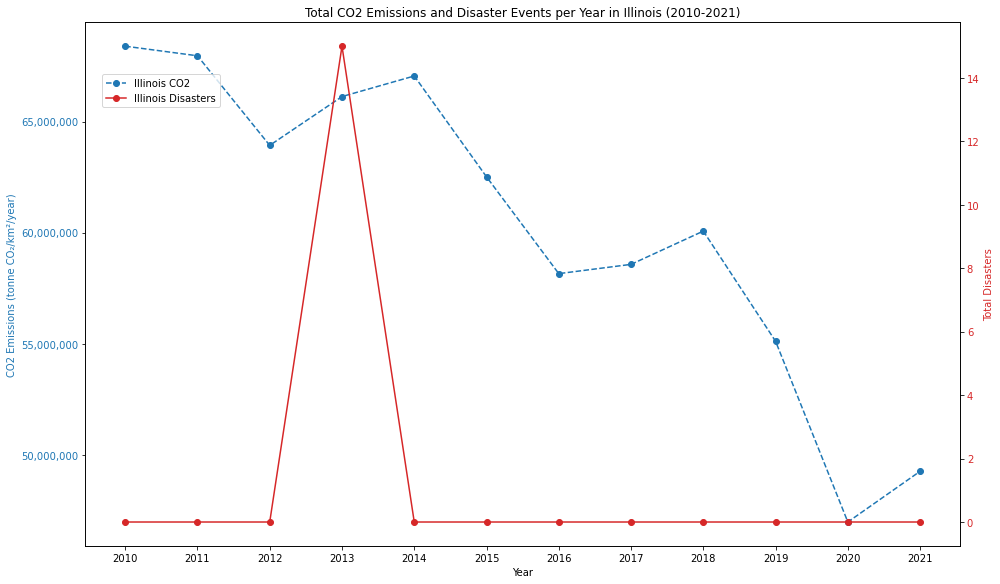

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Indiana-total-co2.csv


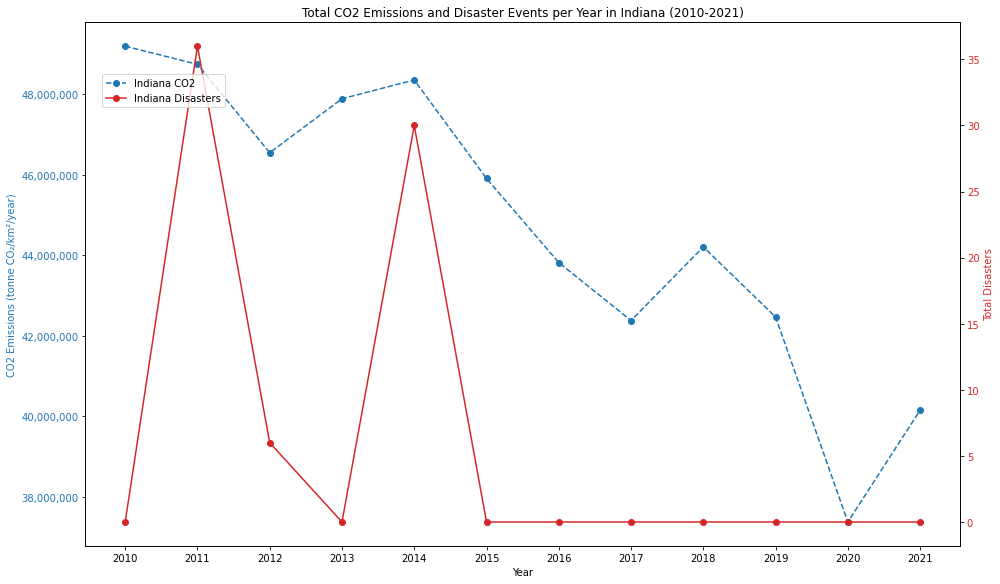

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Iowa-total-co2.csv


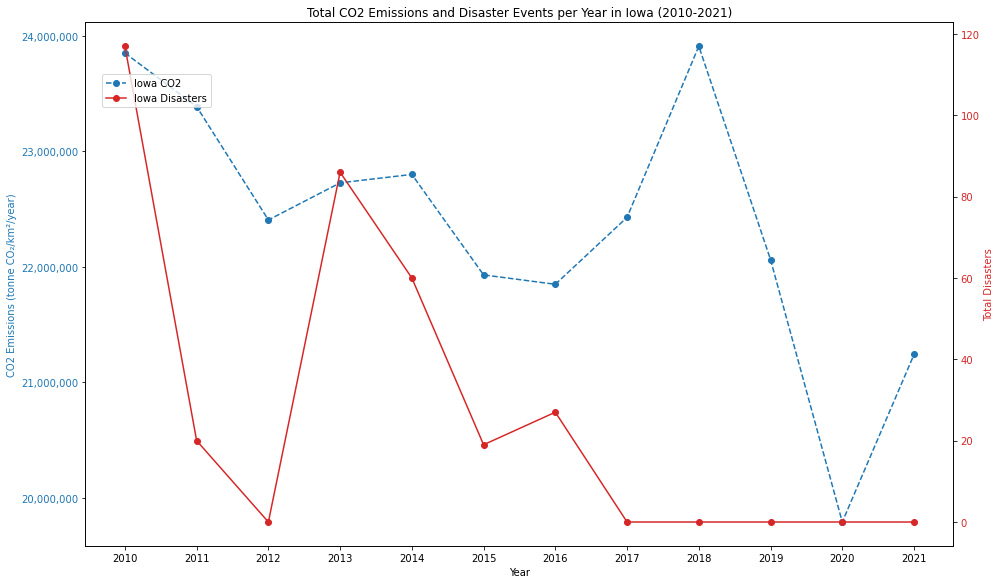

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Kansas-total-co2.csv


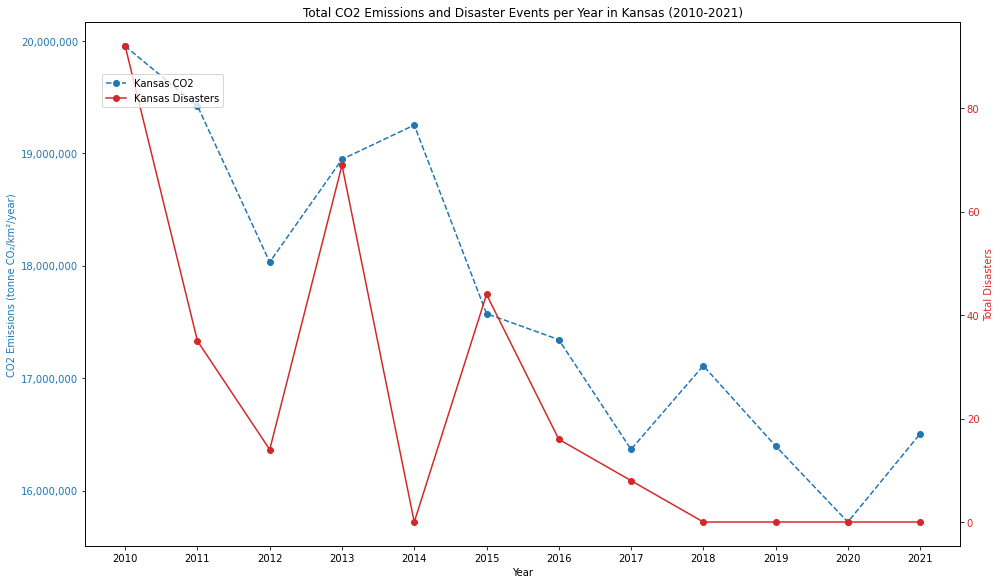

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Kentucky-total-co2.csv


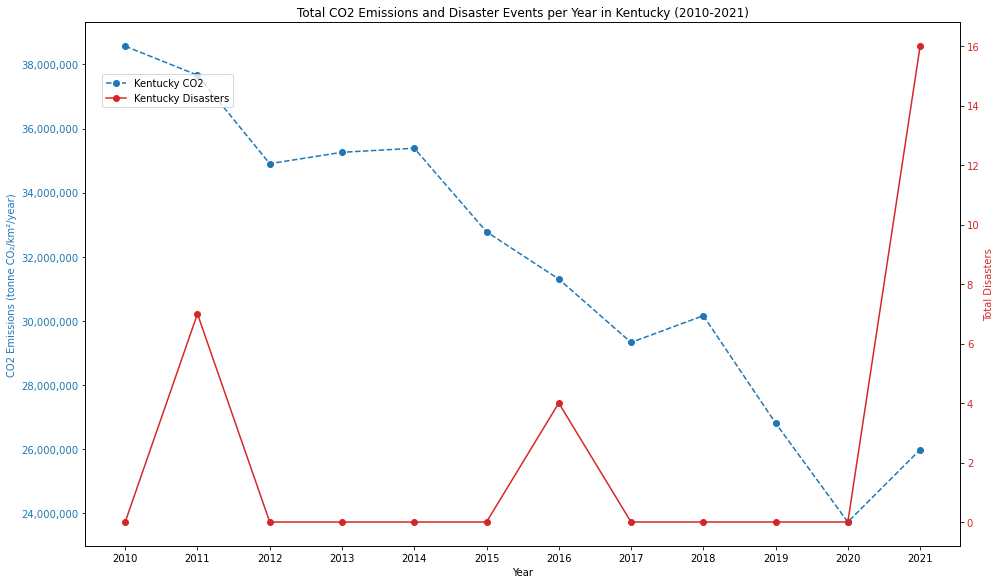

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Louisiana-total-co2.csv


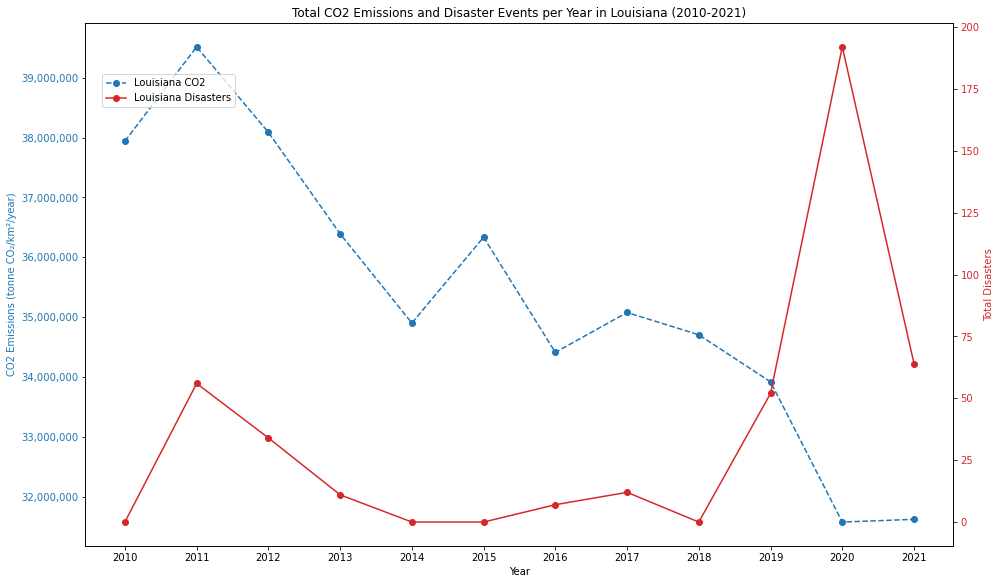

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Maine-total-co2.csv


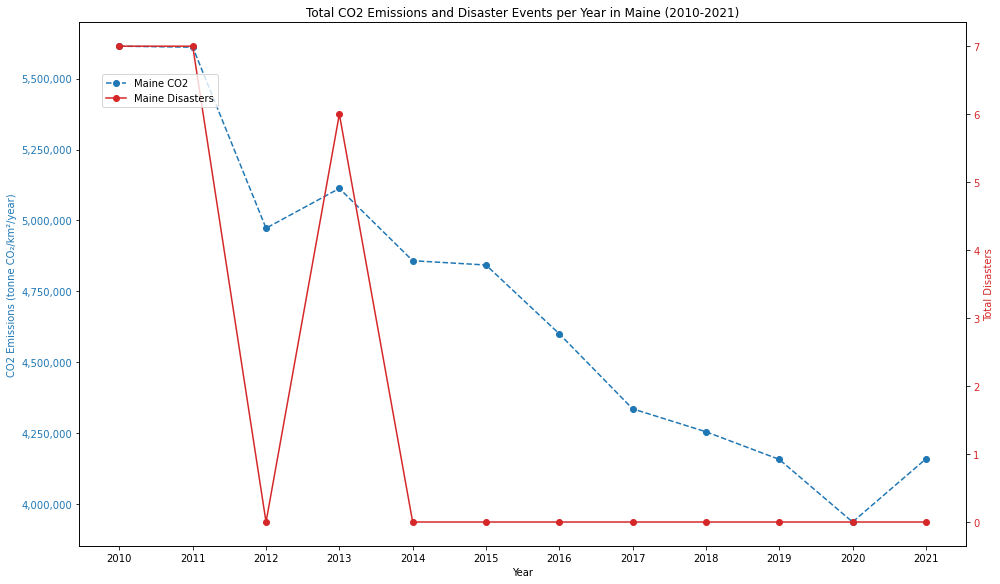

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Maryland-total-co2.csv


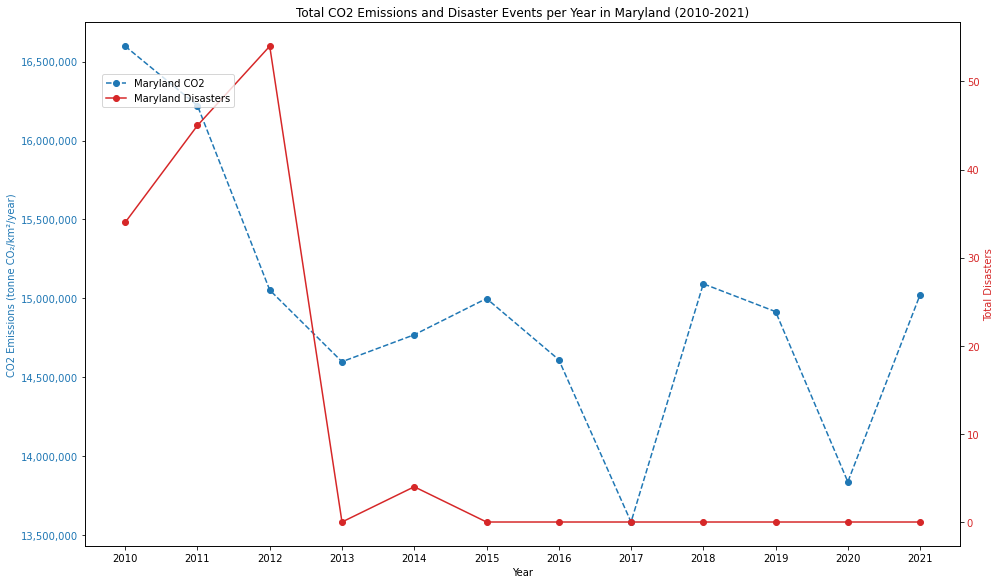

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Massachusetts-total-co2.csv


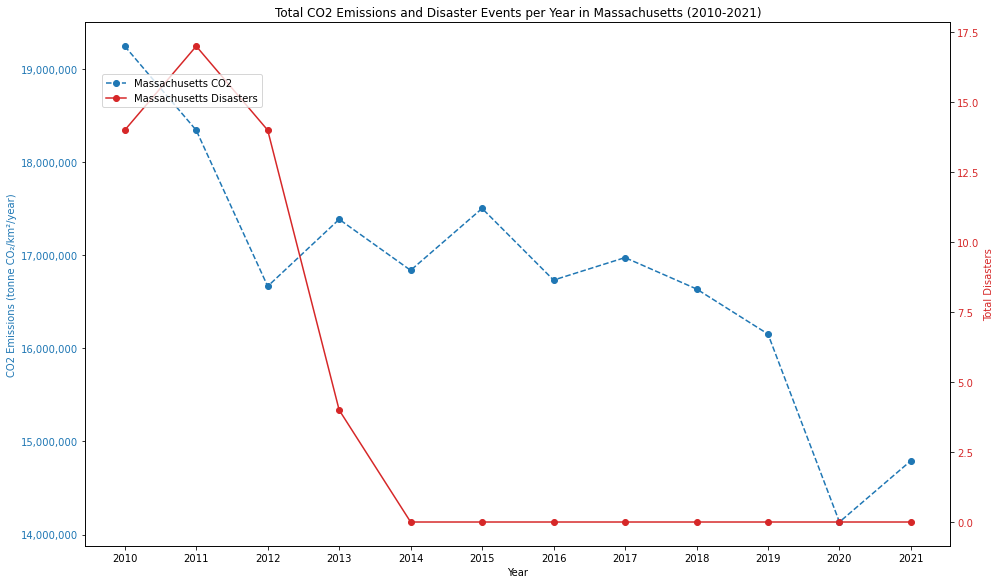

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Michigan-total-co2.csv


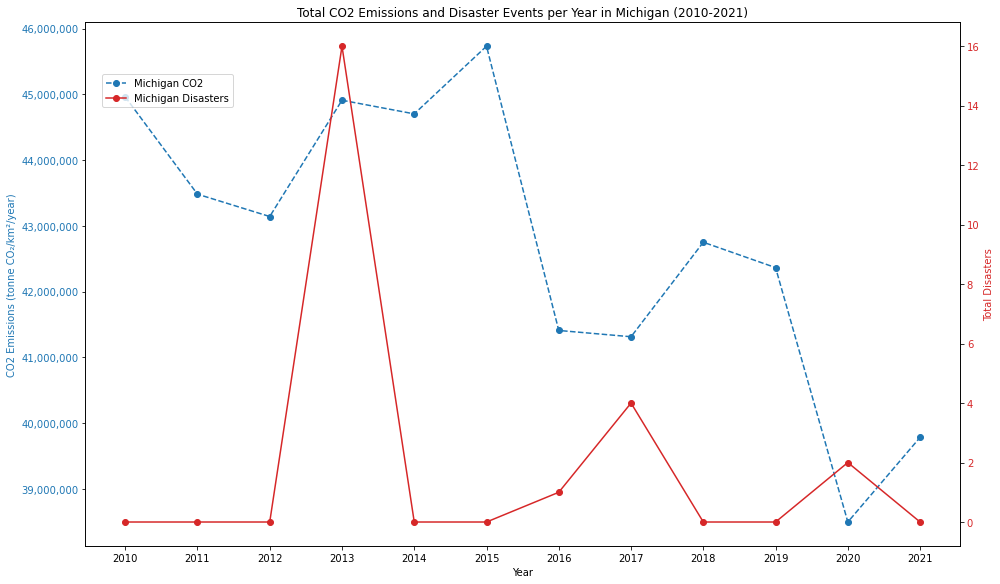

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Minnesota-total-co2.csv


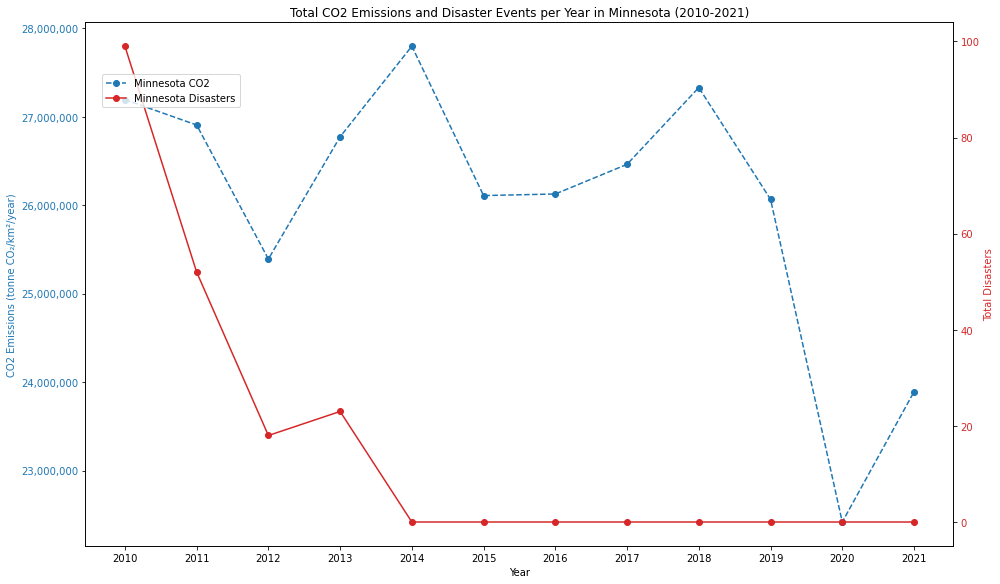

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Mississippi-total-co2.csv


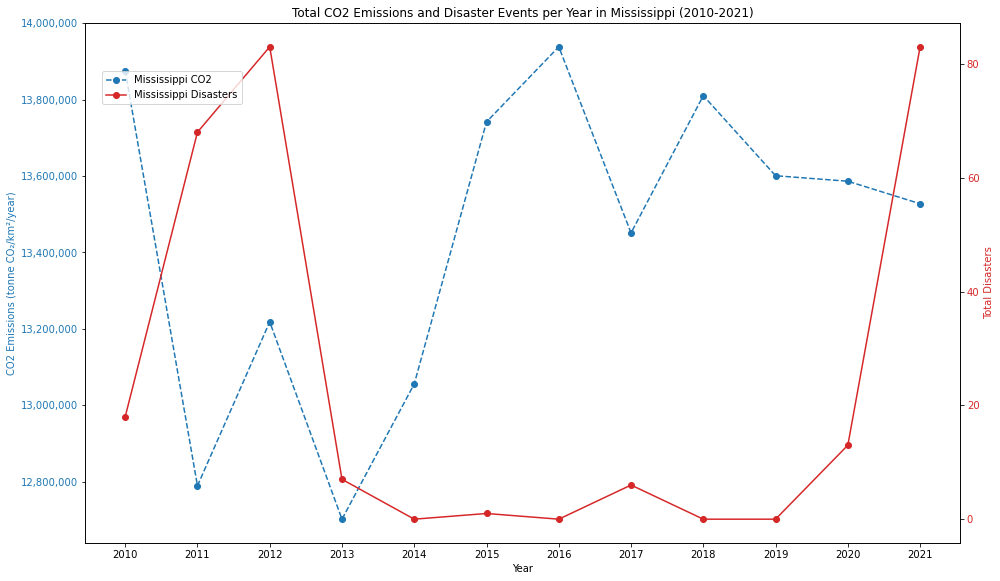

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Missouri-total-co2.csv


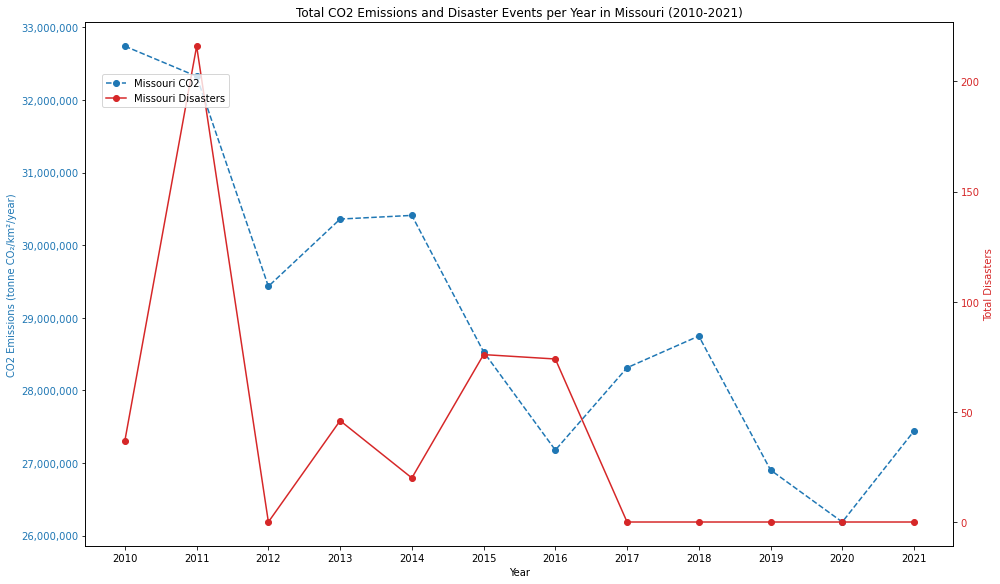

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Montana-total-co2.csv


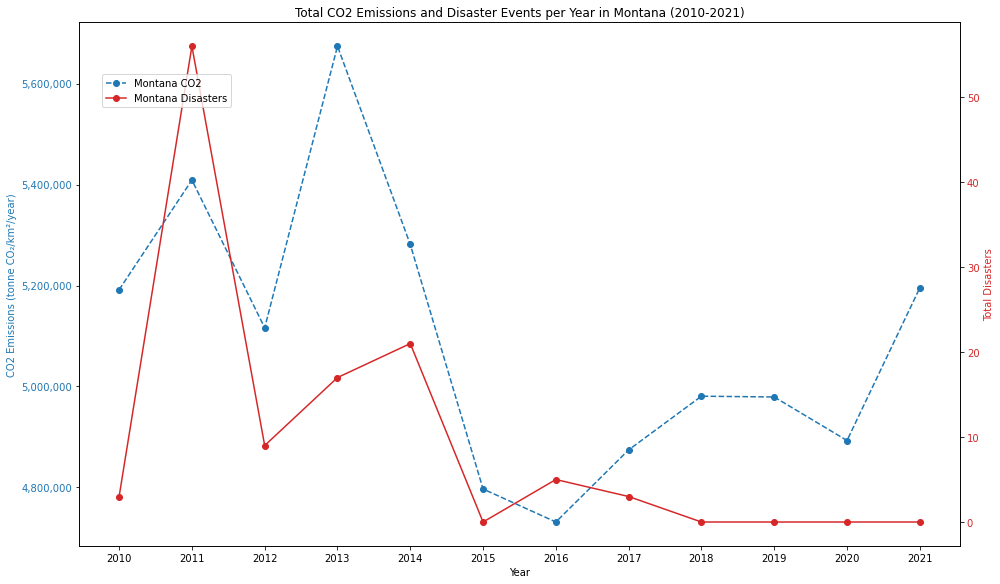

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Nebraska-total-co2.csv


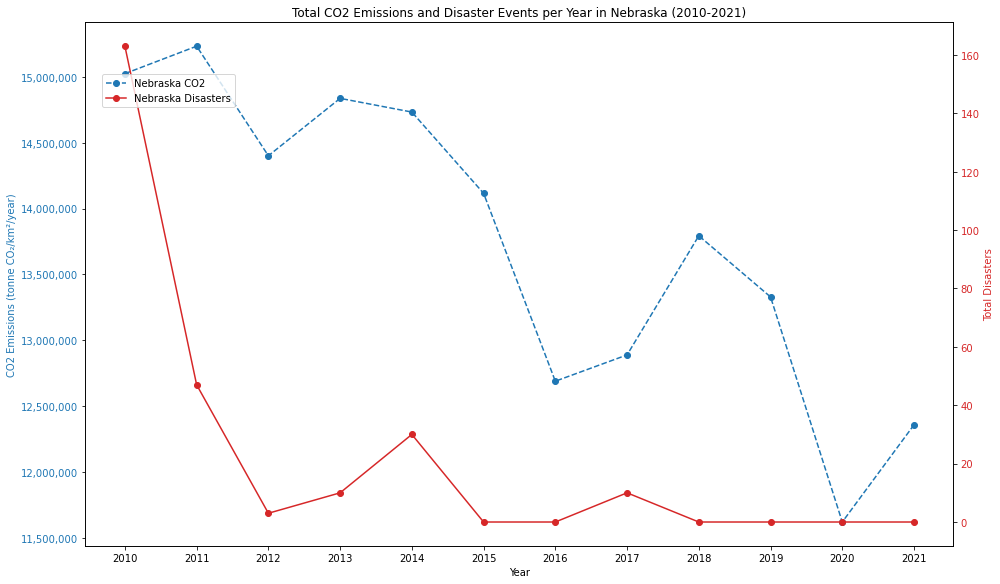

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Nevada-total-co2.csv


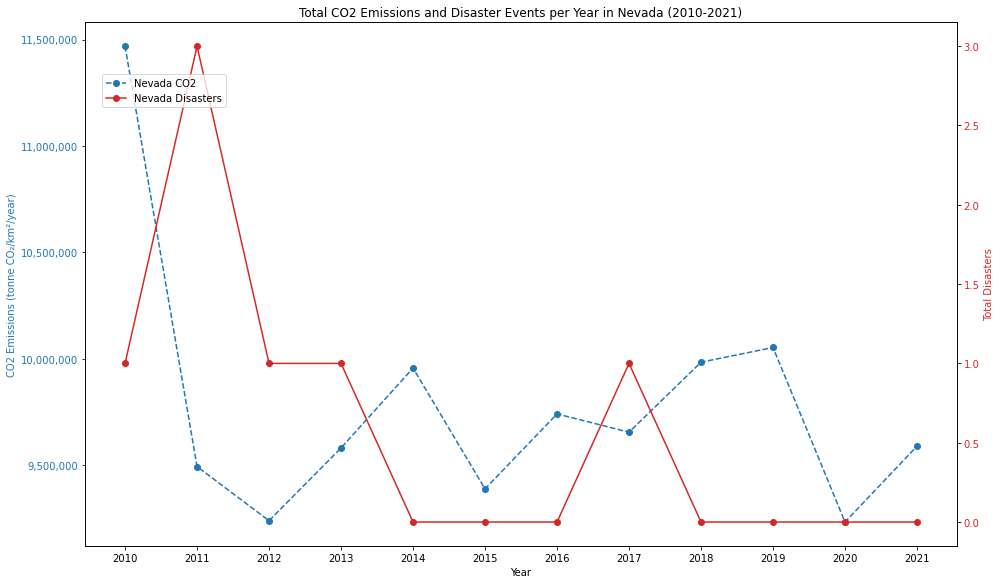

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\New Hampshire-total-co2.csv


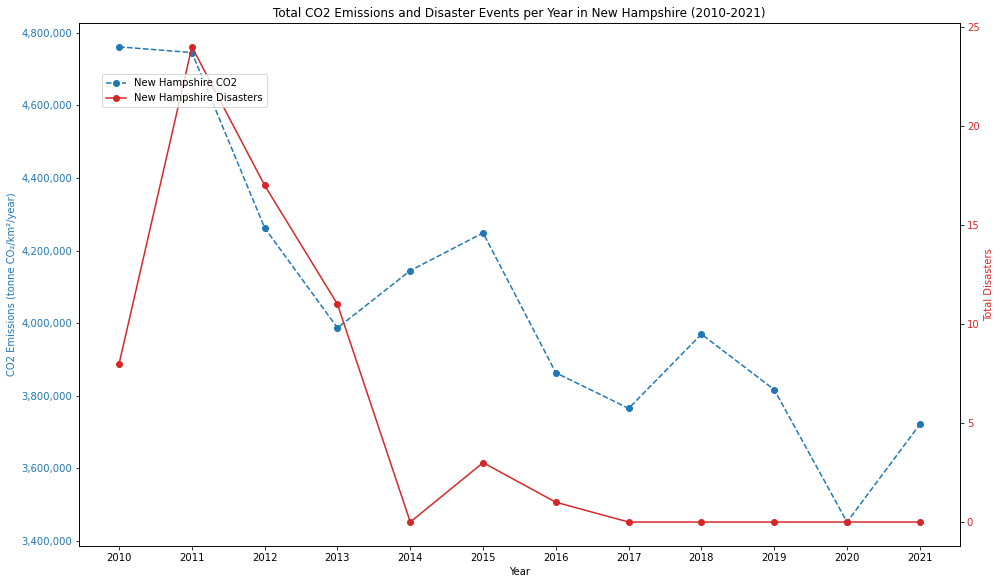

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\New Jersey-total-co2.csv


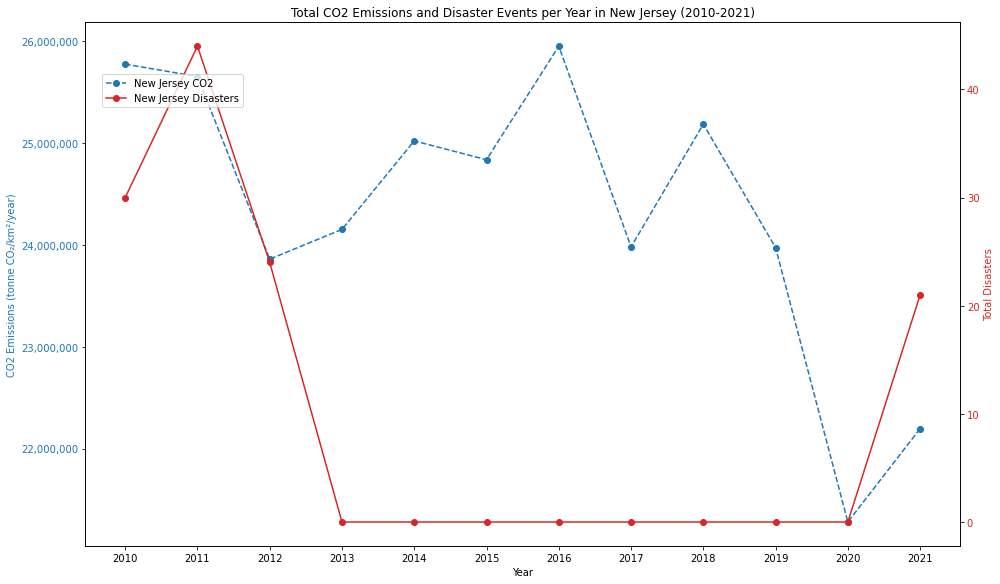

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\New Mexico-total-co2.csv


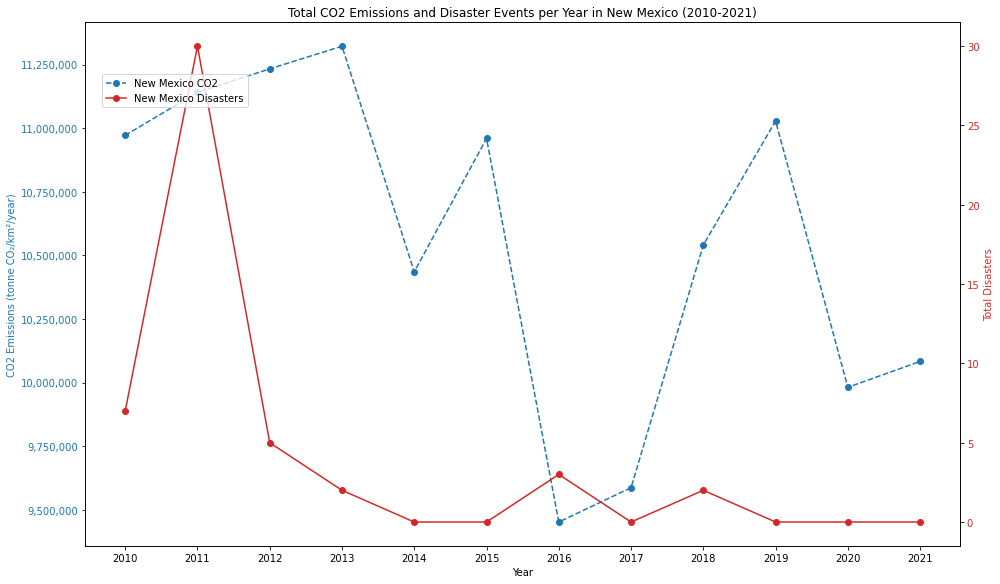

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\New York-total-co2.csv


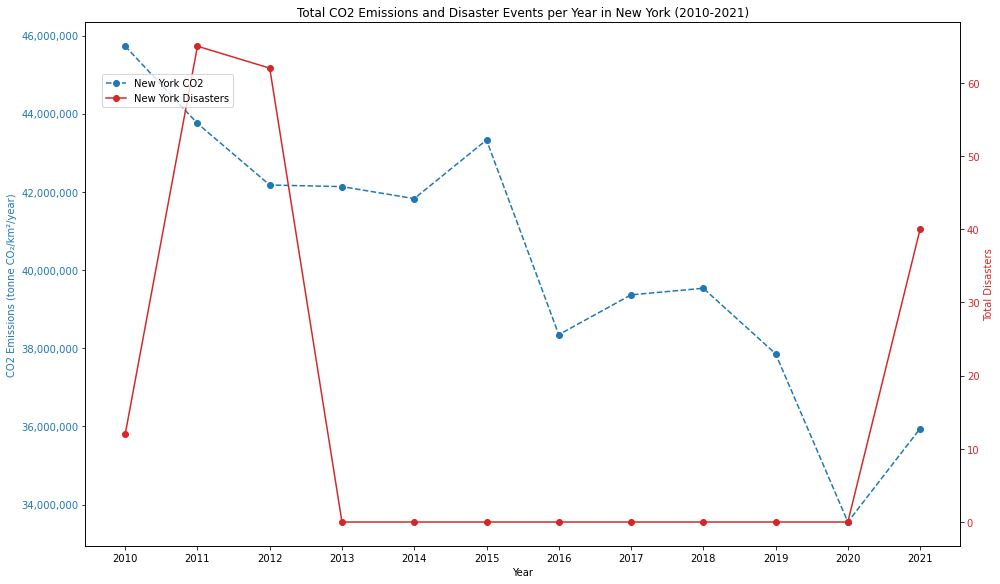

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\North Carolina-total-co2.csv


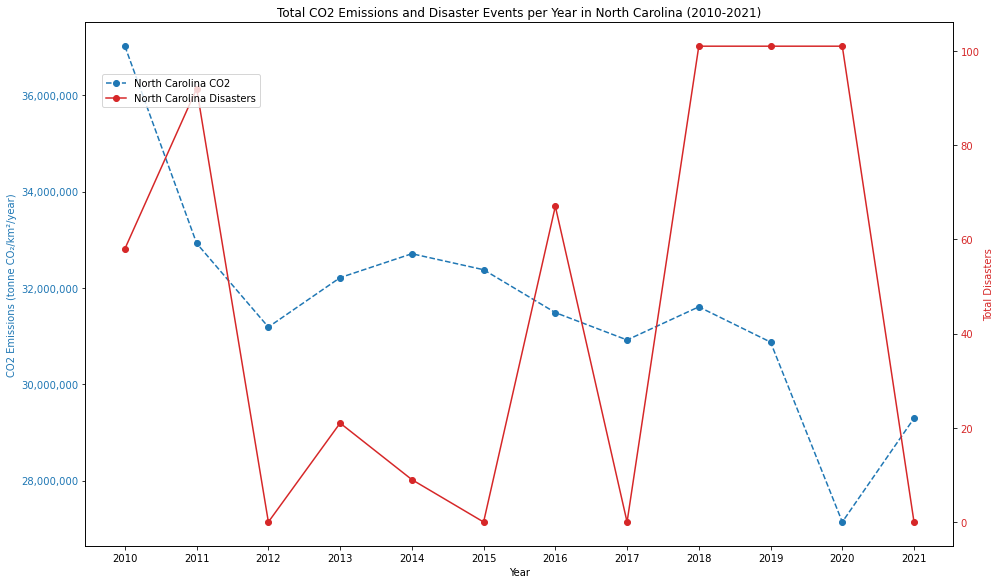

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\North Dakota-total-co2.csv


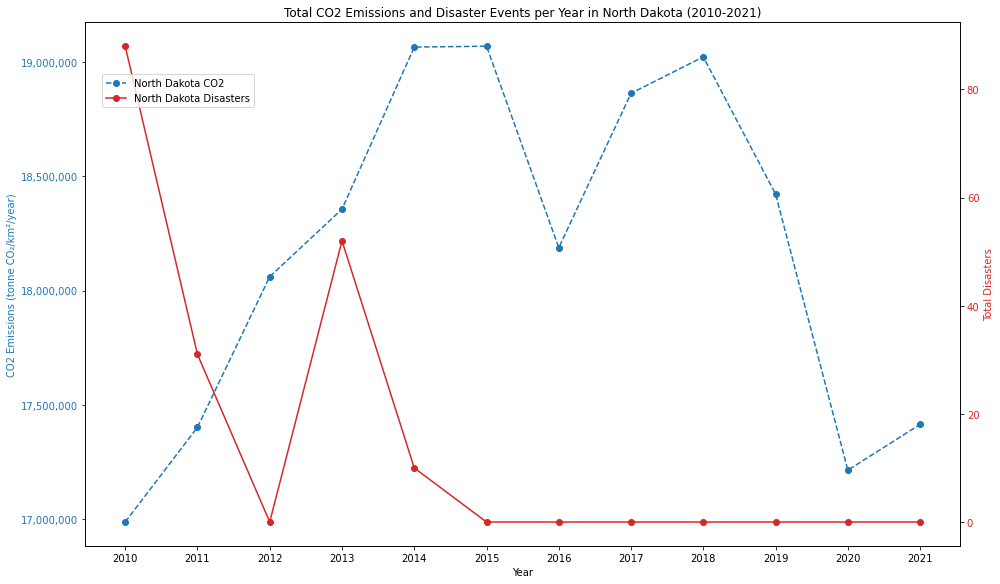

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Ohio-total-co2.csv


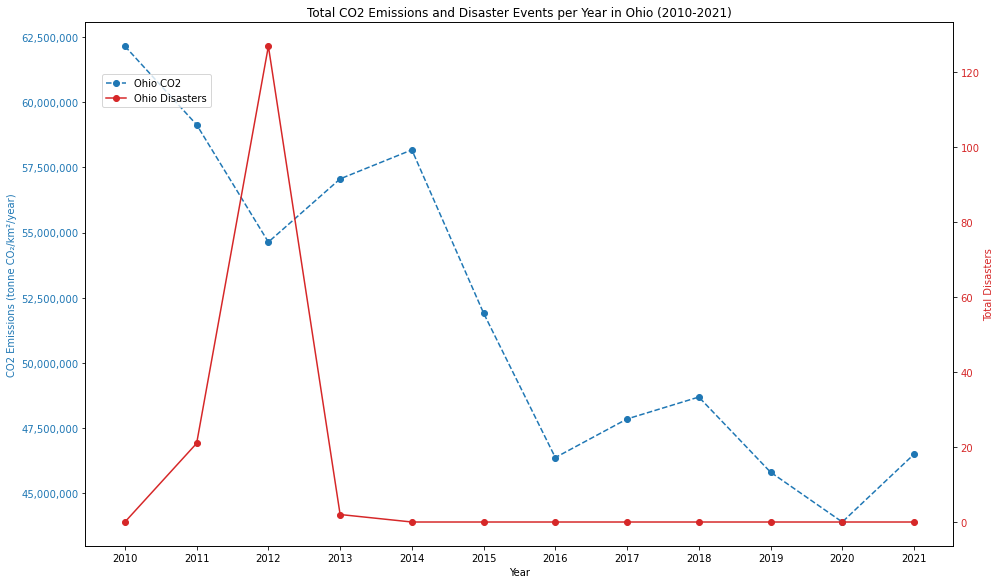

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Oklahoma-total-co2.csv


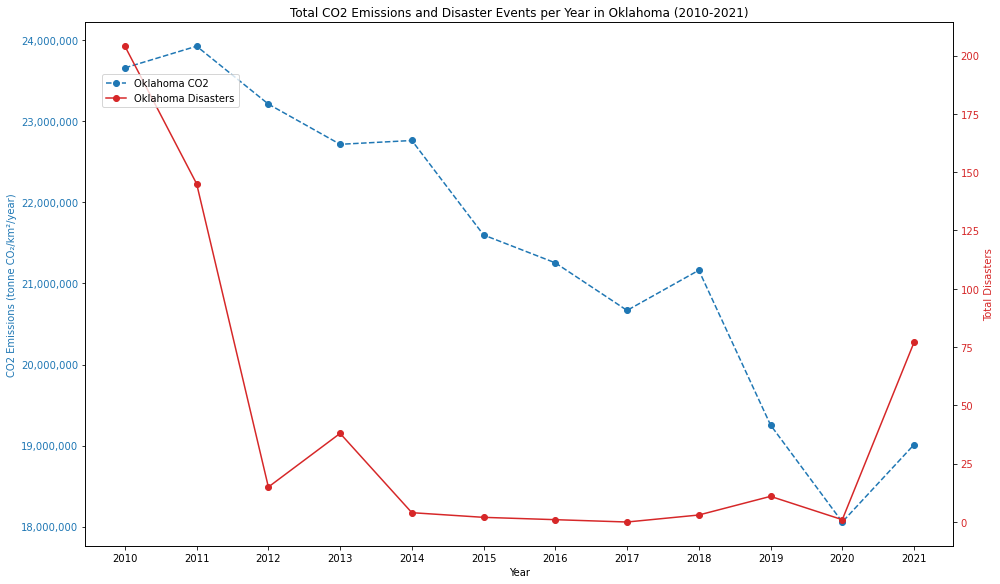

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Oregon-total-co2.csv


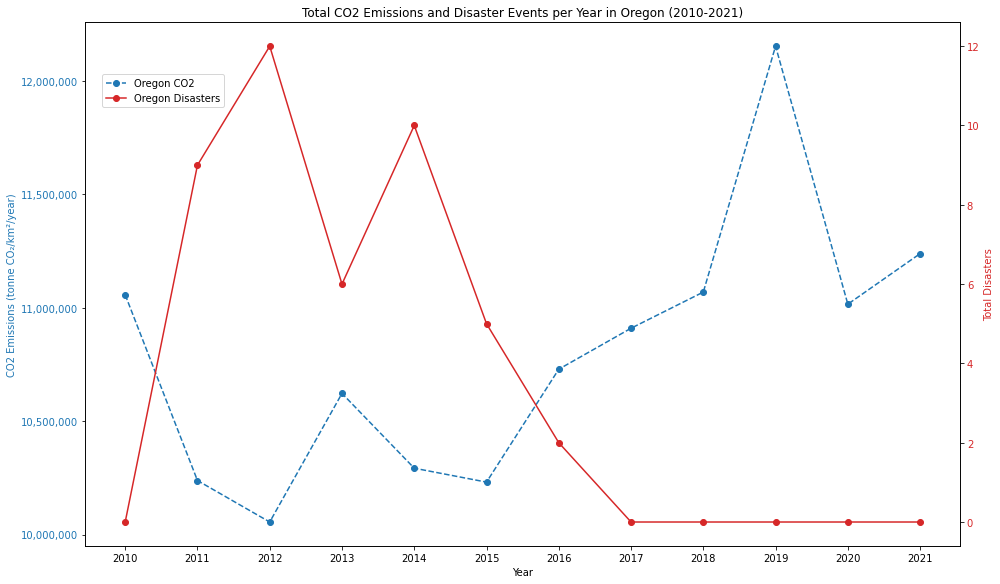

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Pennsylvania-total-co2.csv


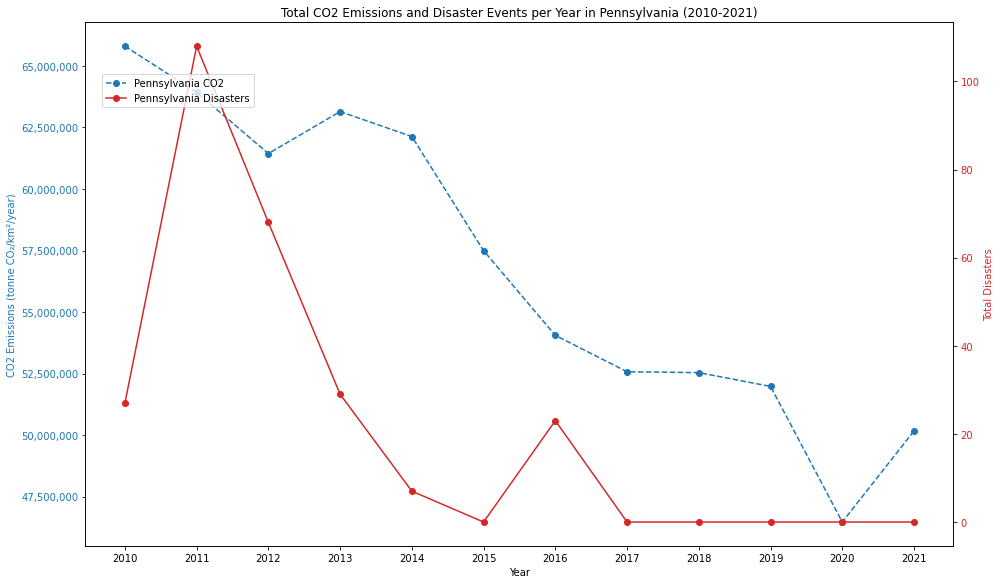

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Rhode Island-total-co2.csv


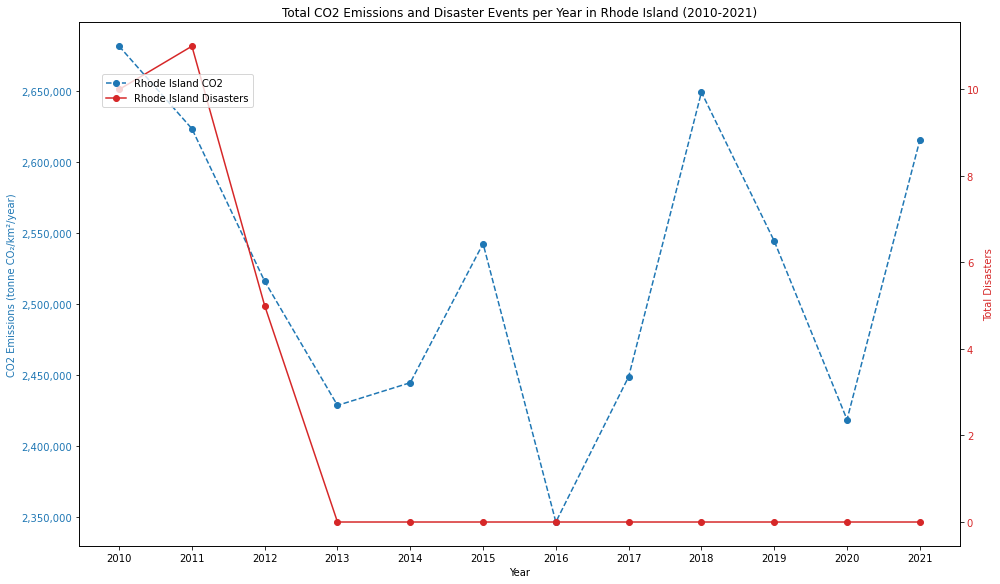

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\South Carolina-total-co2.csv


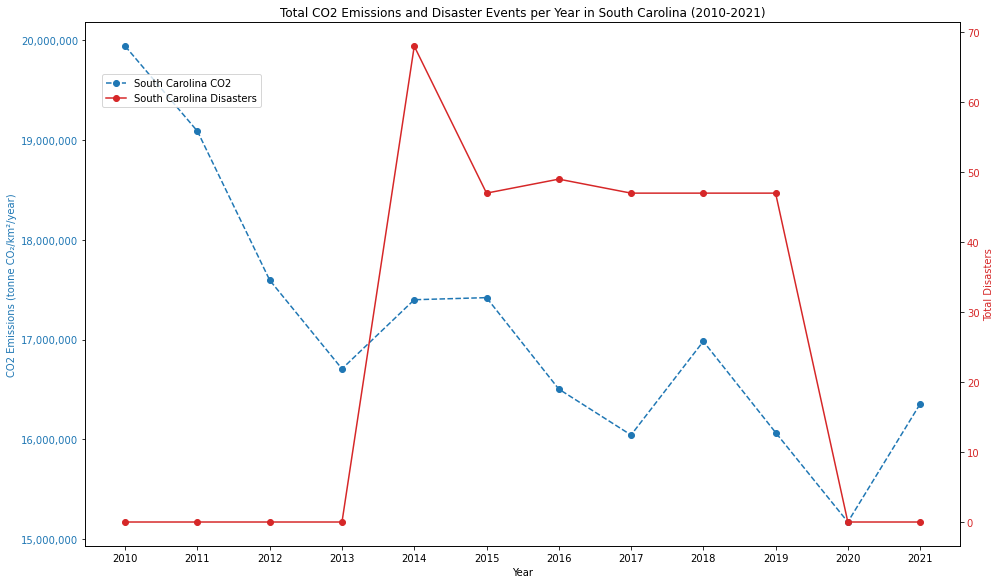

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\South Dakota-total-co2.csv


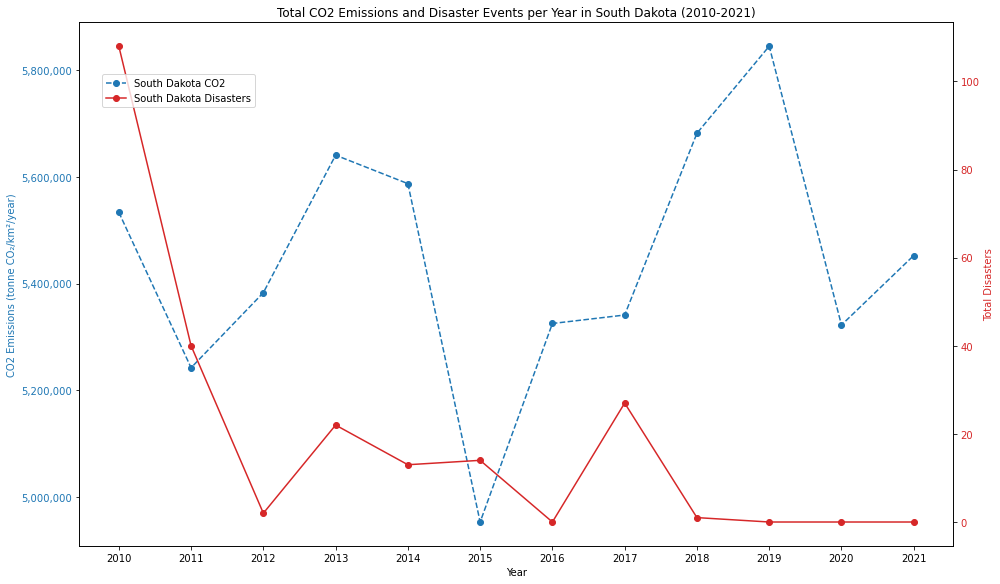

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Tennessee-total-co2.csv


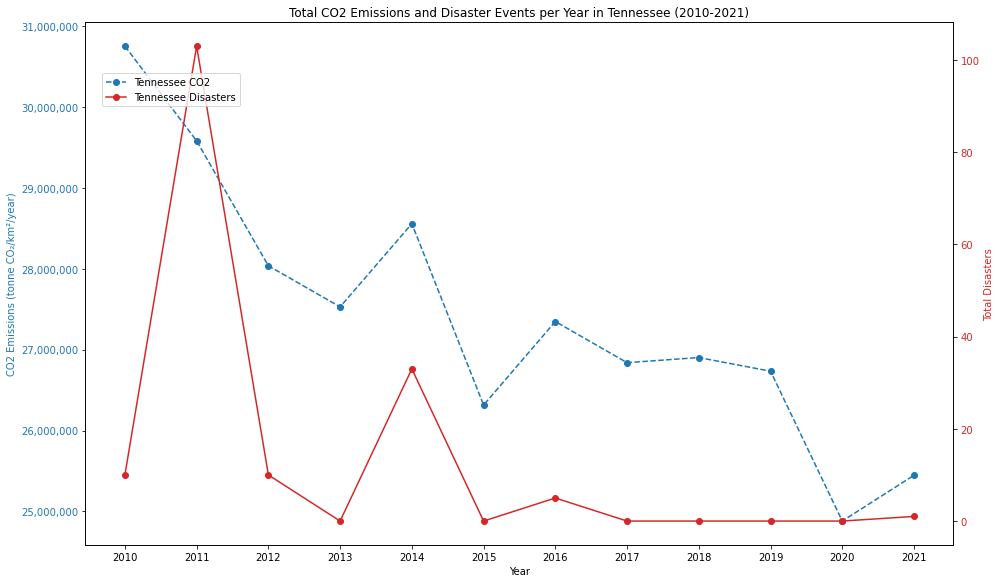

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Texas-total-co2.csv


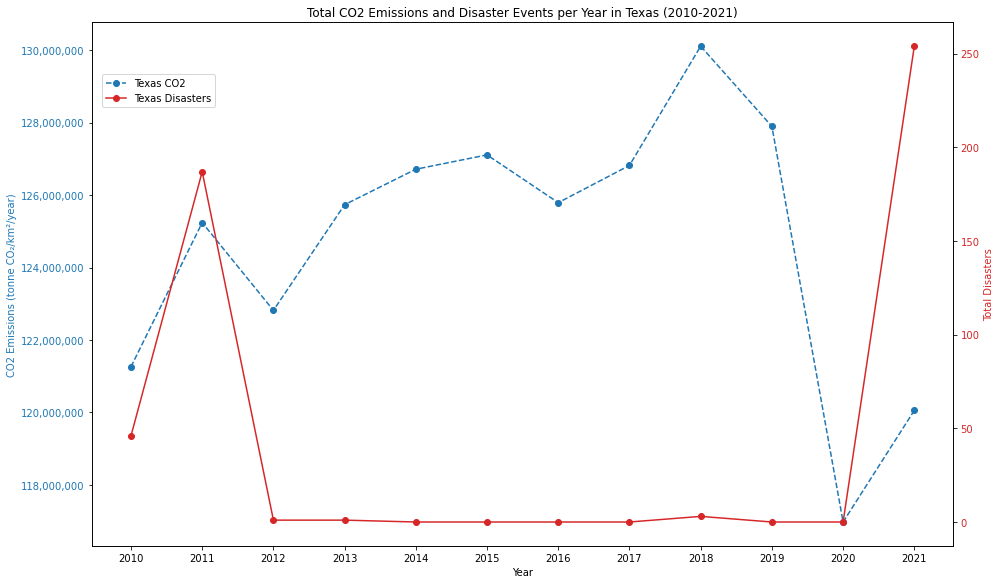

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Utah-total-co2.csv


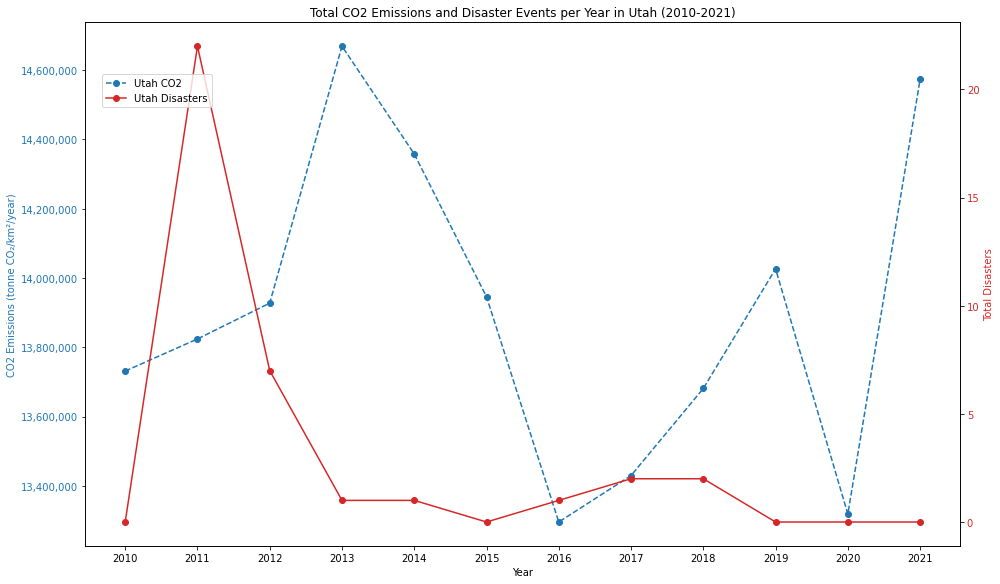

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Vermont-total-co2.csv


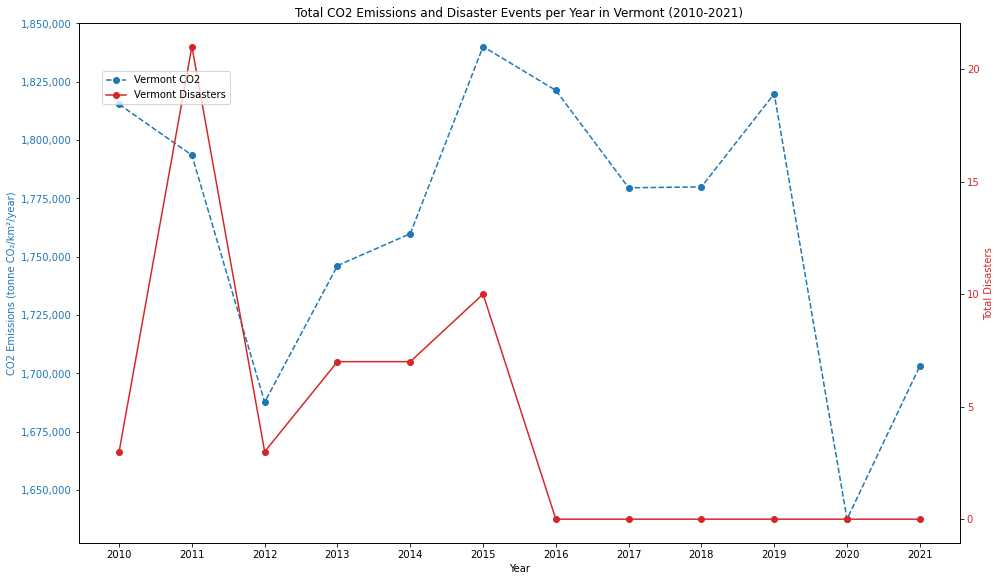

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Virginia-total-co2.csv


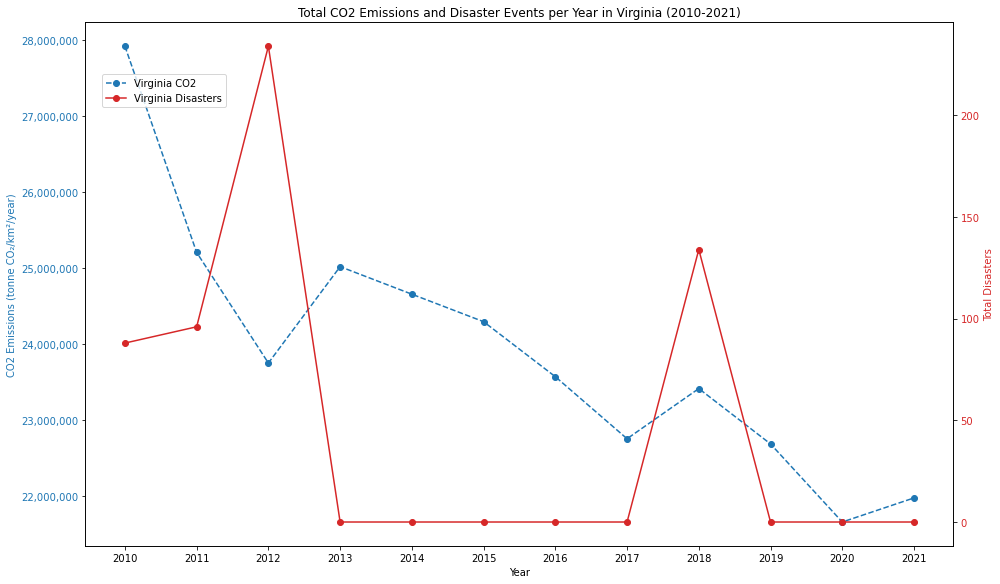

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Washington-total-co2.csv


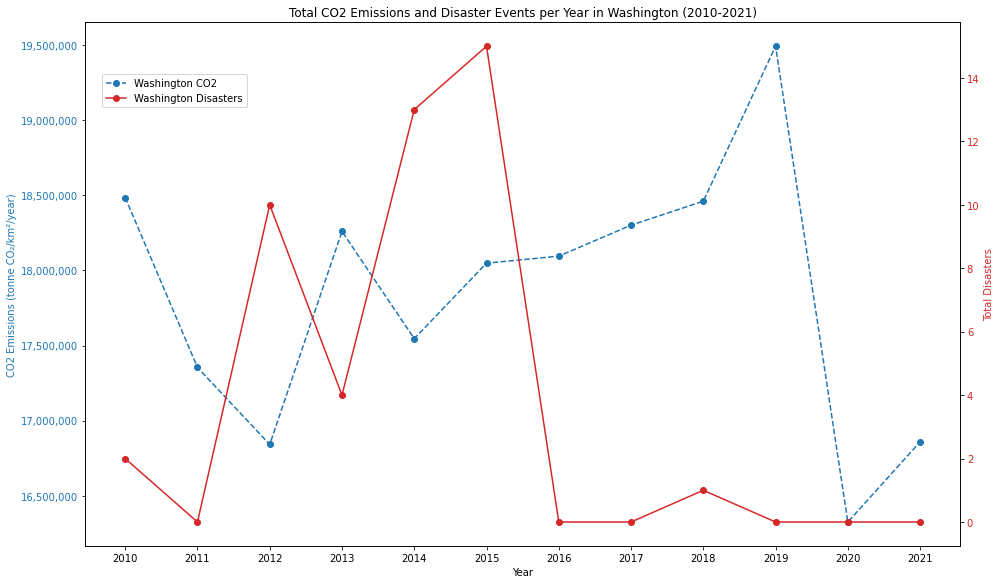

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\West Virginia-total-co2.csv


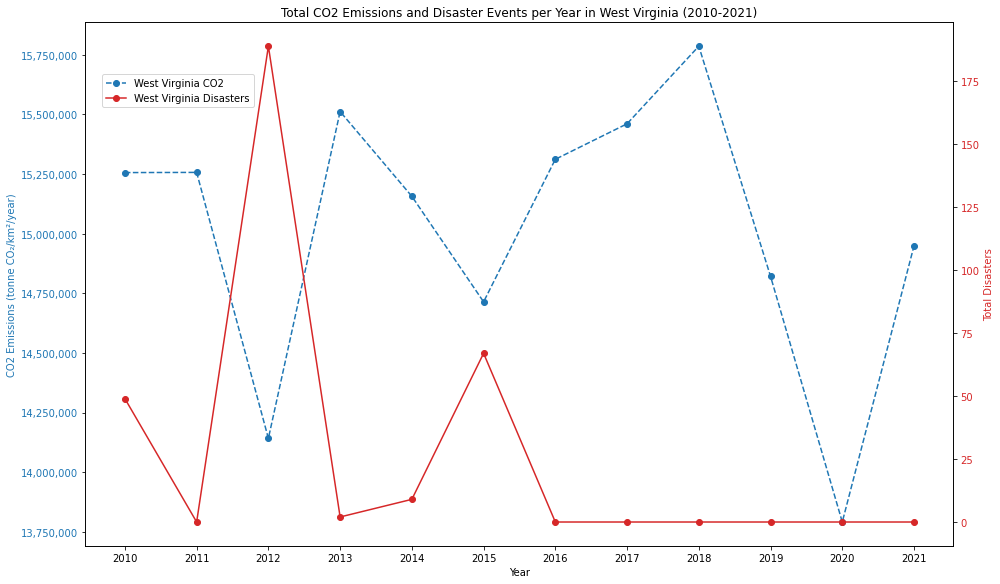

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Wisconsin-total-co2.csv


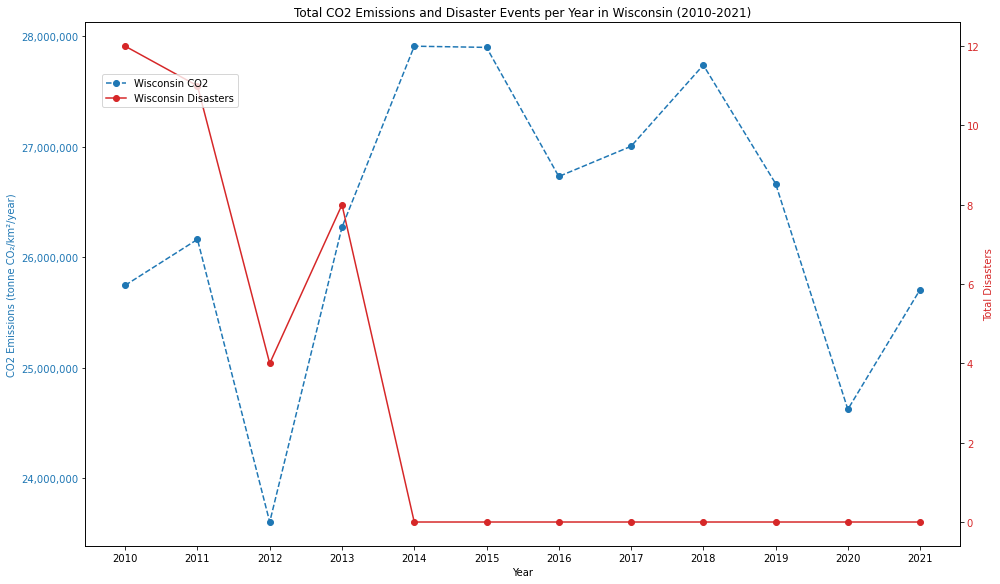

D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total\Wyoming-total-co2.csv


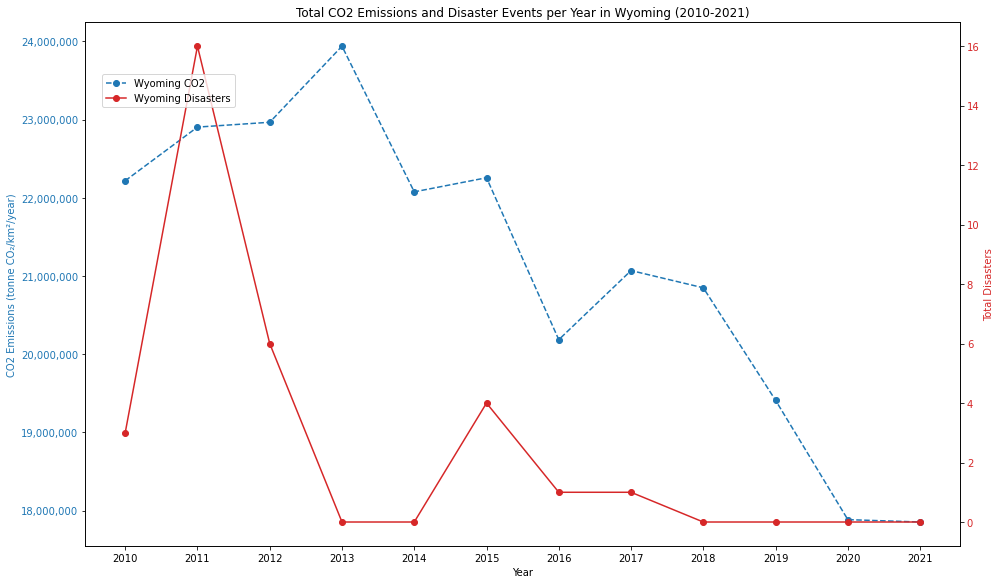

In [47]:
co2_dir = r'D:\OneDrive\StudyMat\CarbonSci-cle-Data\data\raw\co2\total'
output = r'D:\OneDrive\StudyMat\CarbonSci-cle-Data\plot\co2_disasters'
range = (2010, 2021)

plot_co2_and_disasters(co2_dir, pivot_df, output, range)

In [53]:
def plot_total_us_co2_and_disasters(co2_dir, pivot_df, output_dir, year_range):
    # Load all CO2 emissions CSV files and aggregate the data
    co2_file_paths = glob.glob(os.path.join(co2_dir, '*.csv'))
    co2_df_list = []
    for co2_file in co2_file_paths:
        df = pd.read_csv(co2_file)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['year'] = df['datetime'].dt.year.astype(int)
        df = df.groupby('year')['sum'].sum().reset_index(name='total_co2_emissions')
        co2_df_list.append(df)
    
    # Concatenate all CO2 dataframes and aggregate by year
    co2_df = pd.concat(co2_df_list)
    co2_df = co2_df.groupby('year')['total_co2_emissions'].sum().reset_index()

    # Ensure the pivot table index is of the correct data type
    pivot_df.index = pivot_df.index.astype(int)

    # Filter the pivot table to include only the years in the specified range
    pivot_df_filtered = pivot_df[(pivot_df.index >= year_range[0]) & (pivot_df.index <= year_range[1])]

    # Aggregate the disaster events data for the entire US
    total_disasters_df = pivot_df_filtered.sum(axis=1).reset_index(name='total_disasters')

    # Merge the CO2 emissions data with the disaster events data
    merged_df = pd.merge(co2_df, total_disasters_df, left_on='year', right_on='year', how='inner')

    # Plot the data
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plot CO2 emissions
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CO2 Emissions (tonne CO₂/km²/year)', color='tab:blue')
    ax1.plot(merged_df['year'], merged_df['total_co2_emissions'], label='US CO2', color='tab:blue', linestyle='--', marker='o')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    # Create a second y-axis to plot disaster events
    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Disasters', color='tab:red')
    ax2.plot(merged_df['year'], merged_df['total_disasters'], label='US Disasters', color='tab:red', marker='o')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Add legends
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.title(f'Total CO2 Emissions and Disaster Events per Year in the US ({year_range[0]}-{year_range[1]})')
    plt.savefig(os.path.join(output_dir, 'us_co2_disasters.png'))
    plt.close()

In [54]:
output = r'D:\OneDrive\StudyMat\CarbonSci-cle-Data\plot'
plot_total_us_co2_and_disasters(co2_dir, pivot_df, output, range)